In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# 使用相对路径定位到目标目录
target_dir = os.path.join(current_dir, '..', '1_Rawdata')

# 更改工作目录
os.chdir(target_dir)
print(f"Target working directory: {os.getcwd()}")

Current working directory: f:\Study\Study Files\05大三上\金融统计分析\实验课1\Code
Target working directory: f:\Study\Study Files\05大三上\金融统计分析\实验课1\1_Rawdata


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# 读取数据
data = pd.read_csv('TRD_Mnth.csv')
data = data.drop(['Markettype'], axis=1)

In [3]:
forming_month_j = [1, 3, 6]
holding_month_k = [1, 3, 6]
# forming_month_j = [1]
# holding_month_k = [1]

trade_begin = '2018-01-01'
trade_end = '2019-12-31'

In [4]:
# 确保数据按股票代码和日期排序
data = data.sort_values(['Stkcd', 'Trdmnt'])
data['Trdmnt'] = pd.to_datetime(data['Trdmnt'])

# 设置回测期
#data_trade = data[(data['Trdmnt'] >= trade_begin) & (data['Trdmnt'] <= trade_end)]
data_trade = data[(data['Trdmnt'] >= trade_begin) & (data['Trdmnt'] <= trade_end) & data['Msmvosd'].notnull()]
data = data[data['Msmvosd'].notnull()]

# 初始化一个3x3的DataFrame来保存不同策略的收益
result = pd.DataFrame(index=forming_month_j, columns=holding_month_k)
result_weighted = pd.DataFrame(index=forming_month_j, columns=holding_month_k)

# 初始化结果表格
result_ew = pd.DataFrame(index=forming_month_j, columns=holding_month_k)
result_vw = pd.DataFrame(index=forming_month_j, columns=holding_month_k)

In [5]:
# 获取唯一的年月，作为回测的月份点
unique_year_month = pd.PeriodIndex(data_trade['Trdmnt'].dt.to_period('M').unique())

# 开始循环：不同形成期和持有期
for form_period in forming_month_j:
    for hold_period in holding_month_k:

        all_returns = []
        all_returns_winners = []
        all_returns_losers = []
        past_winners = []
        past_losers = []

        all_returns_weighted = []
        all_returns_winners_weighted = []
        all_returns_losers_weighted = []

        # 根据hold_period生成额外的月份
        extra_months = pd.PeriodIndex([unique_year_month[-1] + i for i in range(1, hold_period)], freq='M')
        full_year_month = unique_year_month.union(extra_months)

        # 遍历每一个唯一的年月，包括额外的月份
        for current_ym in full_year_month:
            current_ym_str = str(current_ym)
            current_ym_datetime = pd.to_datetime(current_ym.to_timestamp()).to_pydatetime()
            if current_ym_datetime <= unique_year_month.max().to_timestamp():
                
                end_date = pd.to_datetime(current_ym.to_timestamp())
                start_date = end_date - pd.DateOffset(months=form_period)

                mask = (data['Trdmnt'] > start_date) & (data['Trdmnt'] <= end_date)
                form_returns = data.loc[mask].groupby('Stkcd')['Mretwd'].apply(lambda x: (1 + x).prod() - 1)

                available_stocks = data.loc[data['Trdmnt'] > end_date]['Stkcd'].unique()
                form_returns = form_returns[form_returns.index.isin(available_stocks)]

                #将股票按form_returns大小分为5组
                groups_form_returns = pd.qcut(form_returns, 5, labels=False)

                #赢家股票为form_returns最高的1组
                winners = form_returns[groups_form_returns == 4].index.tolist()

                #输家股票为form_returns最低的1组
                losers = form_returns[groups_form_returns == 0].index.tolist()

                past_winners.append(winners)
                past_losers.append(losers)

                # 如果我们的列表变得过长，就移除旧的元素
                if len(past_winners) > hold_period:
                    past_winners.pop(0)
                    past_losers.pop(0)
            else:
                # 如果不在交易期内，则继续移除旧的元素
                past_winners.pop(0)
                past_losers.pop(0)
            
            # 计算当月所有past_winners和past_losers的平均收益
            mask = (data['Trdmnt'] == str(current_ym))
            current_winner_returns = [
                data.loc[mask & data['Stkcd'].isin(winners_month)]['Mretwd'].mean() 
                for winners_month in past_winners
            ]
            current_loser_returns = [
                data.loc[mask & data['Stkcd'].isin(losers_month)]['Mretwd'].mean() 
                for losers_month in past_losers
            ]
            
            # 取算数平均
            current_winner_return = np.mean(current_winner_returns)
            current_loser_return = np.mean(current_loser_returns)

            # 取加权平均
            current_winner_returns_weighted = [
                np.average(
                    data.loc[mask & data['Stkcd'].isin(winners_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Mretwd'], 
                    weights=data.loc[mask & data['Stkcd'].isin(winners_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Msmvosd']
                )
                for winners_month in past_winners
            ]
            current_loser_returns_weighted = [
                np.average(
                    data.loc[mask & data['Stkcd'].isin(losers_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Mretwd'], 
                    weights=data.loc[mask & data['Stkcd'].isin(losers_month) & data['Mretwd'].notna() & data['Msmvosd'].notna()]['Msmvosd']
                )
                for losers_month in past_losers
            ]

            # 取加权平均
            current_winner_return_weighted = np.nanmean(current_winner_returns_weighted)
            current_loser_return_weighted = np.nanmean(current_loser_returns_weighted)

            # 计算策略收益：赢家收益 - 输家收益
            #strategy_return = current_winner_return - current_loser_return
            all_returns_winners.append(current_winner_return)
            all_returns_losers.append(current_loser_return)

            all_returns_winners_weighted.append(current_winner_return_weighted)
            all_returns_losers_weighted.append(current_loser_return_weighted)

            all_returns.append(current_winner_return - current_loser_return)
            all_returns_weighted.append(current_winner_return_weighted - current_loser_return_weighted)

        # def calculate_annual_returns(all_returns):
        #     all_returns_clean = [x for x in all_returns if not np.isnan(x)]
        #     cumulative_returns = [x + 1 for x in all_returns_clean]
        #     geometric_mean = np.prod(cumulative_returns)**(1/len(cumulative_returns)) - 1
        #     annual_returns = (geometric_mean + 1) ** 12 - 1
        #     return annual_returns
        
        def calculate_geometric_mean_returns(all_returns):
            all_returns_clean = [x for x in all_returns if not np.isnan(x)]
            cumulative_returns = [x + 1 for x in all_returns_clean]
            geometric_mean_returns = np.prod(cumulative_returns)**(1/len(cumulative_returns)) - 1
            return geometric_mean_returns

        # annual_returns = calculate_annual_returns(all_returns)
        # annual_returns_weighted = calculate_annual_returns(all_returns_weighted)

        geometric_mean_returns = calculate_geometric_mean_returns(all_returns)
        geometric_mean_returns_weighted = calculate_geometric_mean_returns(all_returns_weighted)

        result.loc[form_period, hold_period] = geometric_mean_returns
        result_weighted.loc[form_period, hold_period] = geometric_mean_returns_weighted

        # 创建一个 DataFrame 以存储策略收益率
        # strategy_returns = pd.DataFrame({
        #     'EW_mom': all_returns,
        #     'VW_mom': all_returns_weighted
        # }, index=full_year_month)

        ew_mom_series = pd.Series(all_returns)
        vw_mom_series = pd.Series(all_returns_weighted)
        strategy_returns = pd.DataFrame({
            'EW_mom': ew_mom_series,
            'VW_mom': vw_mom_series
        })

        # 对 EW_mom3 进行 Newey-West 标准误差估计
        ew_returns = strategy_returns['EW_mom']
        ew_returns = ew_returns.dropna()
        ew_model = sm.OLS(ew_returns, sm.add_constant(np.ones(len(ew_returns))))
        ew_results = ew_model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

        # 对 VW_mom3 进行 Newey-West 标准误差估计
        vw_returns = strategy_returns['VW_mom']
        vw_returns = vw_returns.dropna()
        vw_model = sm.OLS(vw_returns, sm.add_constant(np.ones(len(vw_returns))))
        vw_results = vw_model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

        print("Equal-weighted momentum strategy regression summary:")
        print(ew_results.summary())
        print("\nValue-weighted momentum strategy regression summary:")
        print(vw_results.summary())

        # 将系数估计和 p 值存储到结果表格中
        if len(ew_results.params) >= 2:
            result_ew.loc[form_period, hold_period] = f"{ew_results.params[1]:.4f}"
            if ew_results.pvalues[1] < 0.01:
                result_ew.loc[form_period, hold_period] += "***"
            elif ew_results.pvalues[1] < 0.05:
                result_ew.loc[form_period, hold_period] += "**"
            elif ew_results.pvalues[1] < 0.1:
                result_ew.loc[form_period, hold_period] += "*"
        else:
            result_ew.loc[form_period, hold_period] = np.nan

        if len(vw_results.params) >= 2:
            result_vw.loc[form_period, hold_period] = f"{vw_results.params[1]:.4f}"
            if vw_results.pvalues[1] < 0.01:
                result_vw.loc[form_period, hold_period] += "***"
            elif vw_results.pvalues[1] < 0.05:
                result_vw.loc[form_period, hold_period] += "**"
            elif vw_results.pvalues[1] < 0.1:
                result_vw.loc[form_period, hold_period] += "*"
        else:
            result_vw.loc[form_period, hold_period] = np.nan


Equal-weighted momentum strategy regression summary:
                            OLS Regression Results                            
Dep. Variable:                 EW_mom   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 08 Oct 2023   Prob (F-statistic):                nan
Time:                        22:04:37   Log-Likelihood:                 47.295
No. Observations:                  24   AIC:                            -92.59
Df Residuals:                      23   BIC:                            -91.41
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [6]:
print(result)
print(result_weighted)

          1         3         6
1  0.260534  0.085106  0.047397
3  0.150446  0.050755  0.030385
6  0.109845  0.039242  0.024185
          1         3         6
1  0.241398  0.080104  0.044507
3  0.129268  0.046361  0.026812
6   0.09272  0.035144  0.022401


In [7]:
# 输出等权重策略和加权策略的结果表格
print("等权重策略结果：")
print(result_ew)
print("\n加权策略结果：")
print(result_vw)

等权重策略结果：
     1    3    6
1  NaN  NaN  NaN
3  NaN  NaN  NaN
6  NaN  NaN  NaN

加权策略结果：
     1    3    6
1  NaN  NaN  NaN
3  NaN  NaN  NaN
6  NaN  NaN  NaN


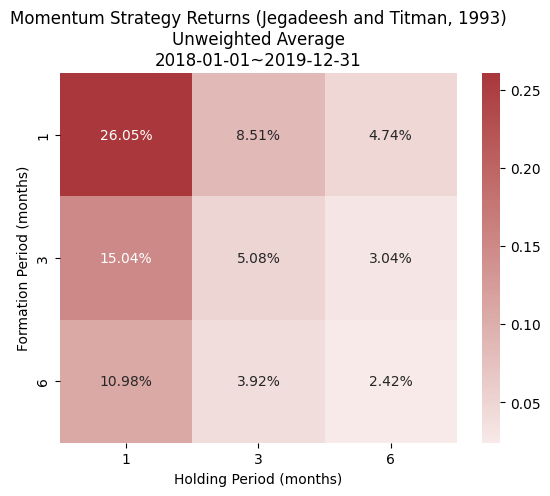

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
sns.heatmap(result.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
title_line1 = "Momentum Strategy Returns (Jegadeesh and Titman, 1993)"
title_line2 = "Unweighted Average"
title_line3 = trade_begin + "~" + trade_end
plt.title(f"{title_line1}\n{title_line2}\n{title_line3}")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")

# 保存图像到'3_Output'文件夹
output_pic_file_name = "Momentum_Strategy_heatmap_" + trade_begin + "~" + trade_end + ".png"
trading_period = trade_begin + "~" + trade_end
output_folder = f'../3_Output/{trading_period}'
os.makedirs(output_folder, exist_ok=True)
output_pic_file_name = "Momentum_Strategy_heatmap_" + trading_period + ".png"
plt.savefig(f'{output_folder}/{output_pic_file_name}')

# 显示图像
plt.show()

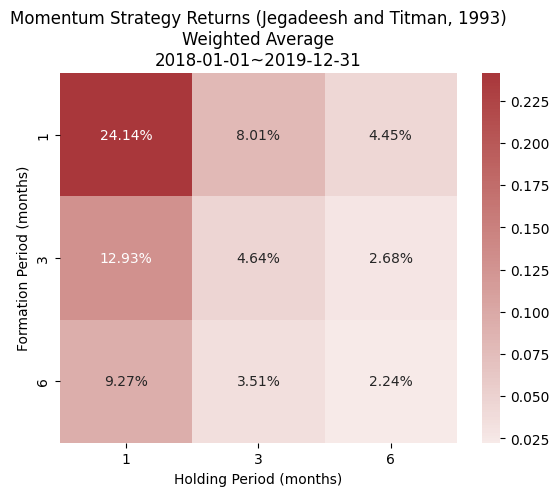

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制热力图
sns.heatmap(result_weighted.astype(float), annot=True, fmt=".2%", cmap="vlag", center=0)
title_line1 = "Momentum Strategy Returns (Jegadeesh and Titman, 1993)"
title_line2 = "Weighted Average"
title_line3 = trade_begin + "~" + trade_end
plt.title(f"{title_line1}\n{title_line2}\n{title_line3}")
plt.xlabel("Holding Period (months)")
plt.ylabel("Formation Period (months)")

# 保存图像到'3_Output'文件夹
output_pic_file_name = "Momentum_Strategy_heatmap_weighted_" + trade_begin + "~" + trade_end + ".png"
trading_period = trade_begin + "~" + trade_end
output_folder = f'../3_Output/{trading_period}'
os.makedirs(output_folder, exist_ok=True)
output_pic_file_name = "Momentum_Strategy_heatmap_weighted_" + trading_period + ".png"
plt.savefig(f'{output_folder}/{output_pic_file_name}')

# 显示图像
plt.show()
